In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X = pd.read_csv('LogReg/X.csv')
y = pd.read_csv('LogReg/y.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Preprocessing

In [ ]:
''' 
Function to scale data without altering nominal features.
Takes 'df' (a dataframe) and 'nominal' (a list of nominal feature names).
Returns the transformed dataframe. 
'''

from sklearn.preprocessing import MinMaxScaler

def scale(df, nominal):

    scaler = MinMaxScaler()

    for var in df.columns:
            
        if var not in nominal:
            raw = df[var].to_numpy()
            raw = raw.reshape(-1, 1)

            scaler.fit(raw)
            scaled = scaler.transform(raw)
            df[var] = scaled

    return df

nominal = ['Marital status', 'Application mode', 'Course',
           'Daytime/evening attendance', 'Previous qualification',
           'Nationality', "Mother's qualification", "Father's qualification",
           "Mother's occupation", "Father's occupation", 'Displaced', 
           'Educational special needs', 'Debtor', 'Tuition fees up to date', 
           'Gender', 'Scholarship holder', 'International']

X = scale(X, nominal)
X_train = scale(X_train, nominal)
X_test = scale(X_test, nominal)

In [ ]:
from category_encoders import TargetEncoder

encoder = TargetEncoder(cols=nominal)

# by only fitting the encoder to the training data, we will be able to see if target leakage is occurring
encoder = encoder.fit(X_train, y_train)

X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)


# Feature Selection

The logistic regression model assumptions require us to perform feature selection before building and tuning a model, especially for the purpose of avoiding multicollinearity.<br>

The process for feature selection isn't straightforward due to the mix of nominal and interval features. <br>
This eliminates wrapper methods like recursive feature elimination because of how the nominal features must be encoded: <br>
 - One-hot/dummy encoding will cause the algorithm to misinterpret the levels of a feature as different features.  <br>
 - Label encoding will cause the algorithm to misinterpret the nominal features as ordinal. <br>
 
We can use filter methods based on statistics like mutual information, but this requires a good deal of subjective interpretation. What is the acceptable threshold? <br>
Tree-based algorithms are the most rigorous approach out of all the supervised methods due to their flexibility. We will use *boruta* and *permutation importance* and compare the results. <br>
The problem with these methods is that they won't account for multicollinearity and are prone to selecting highly correlated features. We will need to investigate this afterward.<br>

Boruta:

In [ ]:
# BORUTA
# use data that is NOT one-hot encoded

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# BorutyPy expects numpy arrays
X_train_np = X_train.values
y_train_np = y_train.values
y_train_np = y_train_np.ravel()
y_test_np = y_test.to_numpy()
y_test_np = y_test_np.ravel()

# fit random forest classifier
rf = RandomForestClassifier(n_jobs=-1, class_weight={0:0.7, 1:0.3}, max_depth=5)
rf.fit(X_train_np, y_train_np)

# initialize and fit Boruta selector
feat_selector = BorutaPy(rf, n_estimators='auto', random_state=1)
feat_selector.fit(X_train_np, y_train_np)

# display selected features
boruta_subset = [feature for feature, keep in zip(X_train.columns, feat_selector.support_) if keep]
boruta_subset

['Application mode',
 'Course',
 'Previous qualification (grade)',
 "Father's occupation",
 'Admission grade',
 'Debtor',
 'Tuition fees up to date',
 'Scholarship holder',
 'Age at enrollment',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)']

Permutation importance:

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

# initialize basic logit classifier
clf = LogisticRegression(solver='newton-cholesky').fit(X_train_encoded, y_train_np) 

# initialize permutation importance
pi = permutation_importance(clf, X_train_encoded, y_train_np,
                           n_repeats=30,
                           random_state=1)

# display results
for i in pi.importances_mean.argsort()[::-1]:
    print(f"{X_train.columns[i]}: {pi.importances_mean[i]*1000:.3}") #multiply mean importance by 1000 for better readability

# something about the multiplication causes the output to display 1.52e+02 as the highest importance value
# 1.52e+02 = 152


Curricular units 2nd sem (approved): 1.52e+02
Tuition fees up to date: 38.0
Curricular units 1st sem (enrolled): 15.8
Curricular units 1st sem (approved): 8.17
Curricular units 2nd sem (grade): 7.46
Curricular units 2nd sem (enrolled): 6.78
Curricular units 1st sem (grade): 3.27
Course: 2.97
Father's occupation: 2.68
Unemployment rate: 2.3
Inflation rate: 1.66
Displaced: 1.58
Debtor: 1.49
Scholarship holder: 1.49
Father's qualification: 1.37
Admission grade: 1.29
Mother's qualification: 1.26
Age at enrollment: 1.22
Daytime/evening attendance: 1.01
Previous qualification: 0.991
Curricular units 2nd sem (evaluations): 0.958
Application order: 0.764
Application mode: 0.7
Curricular units 1st sem (evaluations): 0.614
Previous qualification (grade): 0.226
GDP: 0.215
Marital status: 0.161
International: 0.0108
Educational special needs: 0.0
Nationality: -1.85e-14
Gender: -0.398
Mother's occupation: -0.463


Let's pick the features with importance >= 1.

In [34]:
pi_subset = [col for col, var in zip(X_train.columns, pi.importances_mean) if var*1000 >= 1.0]
pi_subset

['Course',
 'Daytime/evening attendance',
 "Mother's qualification",
 "Father's qualification",
 "Father's occupation",
 'Admission grade',
 'Displaced',
 'Debtor',
 'Tuition fees up to date',
 'Scholarship holder',
 'Age at enrollment',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)',
 'Unemployment rate',
 'Inflation rate']

Now let's test the subsets and compare accuracy. Since adding more features usually results in better accuracy, we'll test the full feature space as well. We'll add roc-auc plots to see how generalizable each fit is, and to make sure that the full feature space isn't causing overfitting.

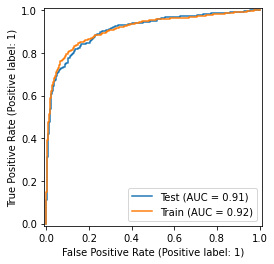

Boruta accuracy: 0.8697289156626506


In [47]:
# BORUTA TEST

from sklearn.linear_model import LogisticRegressionCV

# subset data
X_train_boruta = X_train_encoded[boruta_subset]
X_test_boruta = X_test_encoded[boruta_subset]

# get accuracy score
clf = LogisticRegressionCV(random_state=1, class_weight={0:0.7, 1:0.3}, solver='newton-cholesky').fit(X_train_boruta, y_train_np)
score = clf.score(X_test_boruta, y_test_np)

# ROC
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()

test_auc = RocCurveDisplay.from_estimator(clf, X_test_boruta, y_test, ax=ax, name='Test')
train_auc = RocCurveDisplay.from_estimator(clf, X_train_boruta, y_train, ax=ax, name='Train')

plt.show()

print(f'Boruta accuracy: {score}')

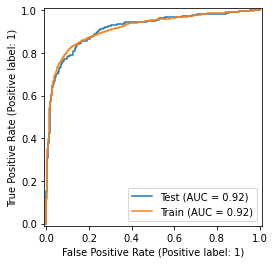

Permuation importance accuracy: 0.8734939759036144


In [ ]:
# PERMUTATION IMPORTANCE TEST

# subset data
X_train_pi = X_train_encoded[pi_subset]
X_test_pi = X_test_encoded[pi_subset]

# get accuracy score
clf = LogisticRegressionCV(random_state=1, solver='newton-cholesky').fit(X_train_pi, y_train_np)
score = clf.score(X_test_pi, y_test_np)

# ROC
fig, ax = plt.subplots()

test_auc = RocCurveDisplay.from_estimator(clf, X_test_pi, y_test, ax=ax, name='Test')
train_auc = RocCurveDisplay.from_estimator(clf, X_train_pi, y_train, ax=ax, name='Train')

plt.show()

print(f'Permuation importance accuracy: {score}')

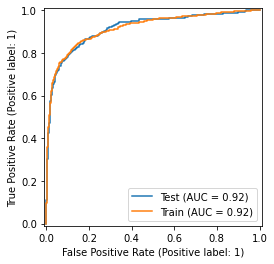

All features accuracy: 0.8780120481927711


In [ ]:
# get accuracy score
clf = LogisticRegressionCV(random_state=1, solver='newton-cholesky').fit(X_train_encoded, y_train_np)
score = clf.score(X_test_encoded, y_test_np)

# ROC
fig, ax = plt.subplots()

test_auc = RocCurveDisplay.from_estimator(clf, X_test_encoded, y_test, ax=ax, name='Test')
train_auc = RocCurveDisplay.from_estimator(clf, X_train_encoded, y_train, ax=ax, name='Train')

plt.show()

print(f'All features accuracy: {score}')

Not only does using the entire feature space give the best accuracy, the fit looks great!<br>
Since we've done our inferential analysis separately, we don't need to worry about interpretability. For this reason, we'll proceed using the full feature set.

In [48]:
# save final, preproccessed training and testing data

X_train_encoded.to_csv('LogReg/X_train.csv', index=False)
X_test_encoded.to_csv('LogReg/X_test.csv', index=False)
y_train.to_csv('LogReg/y_train.csv', index=False)
y_test.to_csv('LogReg/y_test.csv', index=False)

# Model Tuning

In [49]:
#load data

X_train = pd.read_csv('LogReg/X_train.csv')
X_test = pd.read_csv('LogReg/X_test.csv')

y_train = pd.read_csv('LogReg/y_train.csv')
y_test = pd.read_csv('LogReg/y_test.csv')

y_train = y_train.values
y_test = y_test.values

y_train = y_train.ravel()
y_test = y_test.ravel()


### Vanilla

Let's inspect the perfomance of the vanilla model to compare for later. We already looked at the accuracy and ROC-AUC, so now we'll look at the confusion matrix.

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, make_scorer, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

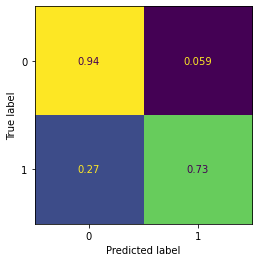

In [ ]:
# CONFUSION MATRIX

clf_vanilla = LogisticRegressionCV(solver='newton-cholesky').fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(clf_vanilla, X_test, y_test, normalize='true', colorbar=False)


The mean accuracy is 0.878<br>
0.59% of true negative cases are falsely predicted. 27% of true positive cases are falsely predicted. That's a huge rate of false negatives. We'd rather have some bias toward false positives, if any. <br>

### Hyperparameters

Use grid search to evaluate the different possible parameter combinations.

In [ ]:
from sklearn.model_selection import GridSearchCV

# define possible parameters
parameters = {'penalty':['l1', 'l2'], # exclude penalties 'none' and 'elasticnet' because they produce NaN
              'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'saga'], # exclude sag because it never converges
              'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]} # use logarithmic scale to test wide range of C values 

# fit 
lrg = LogisticRegression(max_iter=500)
f1 = make_scorer(f1_score)
clf = GridSearchCV(lrg, parameters, scoring=['accuracy', 'recall', 'f1'], return_train_score=True, refit=False)

clf.fit(X_train, y_train)

# store results
gs_results = pd.DataFrame(clf.cv_results_)

c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: T

Filter the results dataframe and reformat into a digestible form.

In [62]:
# remove rows with NaN
# these rows represent incompatible parameter combinations
gs_results = gs_results.dropna(axis=0)

# columns of interest
columns = ['param_C', 'param_penalty', 'param_solver', 
           'mean_test_accuracy', 
           'mean_test_recall', 
           'mean_test_f1']


In [63]:
# VIEW HIGHEST RECALL
# prioritize recall over precision to help balance the error ratios
gs_recall = gs_results[columns].sort_values(by='mean_test_recall', axis=0, ascending=False, ignore_index=True)
gs_recall.head()

,param_C,param_penalty,param_solver,mean_test_accuracy,mean_test_recall,mean_test_f1
0,10000.0,l2,saga,0.870483,0.723979,0.786549
1,10000.0,l1,saga,0.870483,0.723979,0.786549
2,1000.0,l1,saga,0.870483,0.723979,0.786549
3,1000.0,l2,saga,0.870483,0.723979,0.786549
4,10.0,l2,lbfgs,0.869191,0.723003,0.784564


In [64]:
# VIEW HIGHEST F1 SCORE
gs_f1 = gs_results[columns].sort_values(by='mean_test_f1', axis=0, ascending=False, ignore_index=True)
gs_f1.head()

,param_C,param_penalty,param_solver,mean_test_accuracy,mean_test_recall,mean_test_f1
0,10000.0,l2,saga,0.870483,0.723979,0.786549
1,10000.0,l1,saga,0.870483,0.723979,0.786549
2,1000.0,l2,saga,0.870483,0.723979,0.786549
3,1000.0,l1,saga,0.870483,0.723979,0.786549
4,100.0,l2,saga,0.869836,0.722993,0.785431


In [65]:
# VIEW HIGHEST ACCURACY
gs_accuracy = gs_results[columns].sort_values(by='mean_test_accuracy', axis=0, ascending=False, ignore_index=True)
gs_accuracy.head()

,param_C,param_penalty,param_solver,mean_test_accuracy,mean_test_recall,mean_test_f1
0,10000.0,l2,saga,0.870483,0.723979,0.786549
1,10000.0,l1,saga,0.870483,0.723979,0.786549
2,1000.0,l1,saga,0.870483,0.723979,0.786549
3,1000.0,l2,saga,0.870483,0.723979,0.786549
4,100.0,l1,saga,0.869836,0.722993,0.785431


In [66]:
# VIEW LOWEST ACCURACY
low_acc = gs_results[columns].sort_values(by='mean_test_accuracy', axis=0, ascending=True, ignore_index=True)
low_acc.head()

,param_C,param_penalty,param_solver,mean_test_accuracy,mean_test_recall,mean_test_f1
0,0.001,l1,liblinear,0.671189,0.0,0.0
1,0.001,l1,saga,0.671189,0.0,0.0
2,0.001,l2,lbfgs,0.671189,0.0,0.0
3,0.001,l2,liblinear,0.671189,0.0,0.0
4,0.001,l2,newton-cg,0.671189,0.0,0.0


The same model achieves the highest F1 score, recall, and accuracy. <br>
Clearly, the model prefers high C values and the saga solver. The model is insensitive to regularization type.<br>
The winning parameters are:
- C = 1000
- penalty = l2
- solver = saga

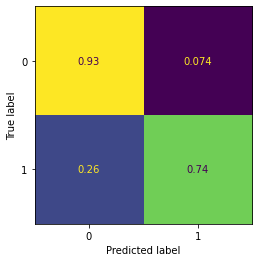

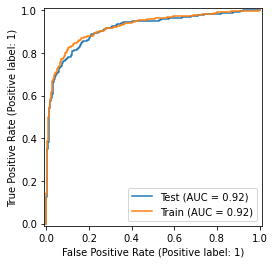

In [71]:
# CONFUSION MATRIX
import matplotlib.pyplot as plt

clf_param_tuned = LogisticRegression(C=1000, penalty='l2', solver='saga', max_iter=10000).fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(clf_param_tuned, X_test, y_test, normalize='true', colorbar=False)

# ROC
fig, ax = plt.subplots()

test_auc = RocCurveDisplay.from_estimator(clf_param_tuned, X_test, y_test, ax=ax, name='Test')
train_auc = RocCurveDisplay.from_estimator(clf_param_tuned, X_train, y_train, ax=ax, name='Train')

plt.show()

The confusion matrix and ROC-AUC are almost identical to the default parameters. We need to tune the decision threshold to fix the extreme error ratio. This is unsurprising given how large our constant coefficient was in the inferential analysis.

### Decision threshold

We'll use Youden's J Statistic to find the threshold closest to the top left corner of the ROC curve. 

Best threshold = 0.3557910652341968


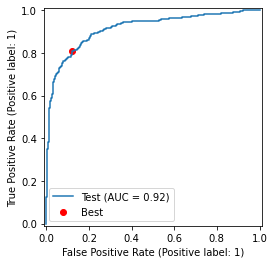

In [72]:
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt

# get probabilities for the positive case
yhat = clf_param_tuned.predict_proba(X_test)[:, 1]

# get roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)

# find best threshold
J = tpr - fpr
idx = np.argmax(J)
best_thresh = thresholds[idx]

print(f'Best threshold = {best_thresh}')

# plot the roc curve showing the optimal threshold
fig, ax = plt.subplots()

test_auc = RocCurveDisplay.from_estimator(clf_param_tuned, X_test, y_test, ax=ax, name='Test')
plt.scatter(fpr[idx], tpr[idx], marker='o', color='red', label='Best')
plt.legend()

plt.show()

Accuracy: 0.8561746987951807


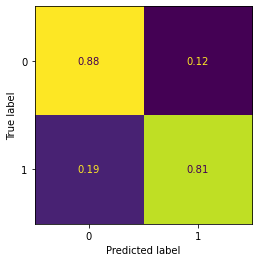

In [73]:
# get class labels using new threshold
y_prob = clf_param_tuned.predict_proba(X_test)[:, 1]
y_pred = np.where(y_prob > best_thresh, 1, 0)

# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', colorbar=False)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Using the new threshold, 19% of true positives are falsely predicted and 12% of true negatives are falsely predicted. This is decently balanced, but we'd like the false positive rate to be a little higher than the false negative rate (the inverse of what is happening). Let's tweak the threshold just a bit to accomplish this. Let's test a few nearby thresholds using cross validation and see what error ratios they produce.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# rejoin train and test sets
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
y = pd.concat([y_train, y_test], axis=0, ignore_index=True)

# get cv folds
skf = StratifiedKFold()

# define thresholds
test_thresholds = np.arange(0.22, 0.30, 0.01)

# create list to store mean model scores
mean_stats = [[] for _ in range(3)]

# test thresholds
for i, threshold in enumerate(test_thresholds):

    stats = [[] for _ in range(3)]

    # for each cv fold
    for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
        
        # train model
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_train = np.ravel(y_train)
        clf_param_tuned.fit(X_train, y_train)
        y_prob = clf_param_tuned.predict_proba(X_test)[:, 1]
        y_pred = np.where(y_prob > threshold, 1, 0)

        # get errors
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        stats[0].append(accuracy_score(y_test, y_pred))
        stats[1].append(cm[0, 1])
        stats[2].append(cm[1, 0])

    # save mean errors across folds
    mean_stats[0].append(np.mean(stats[0]))
    mean_stats[1].append(np.mean(stats[1]))
    mean_stats[2].append(np.mean(stats[2]))

# show results
result = pd.DataFrame({'Threshold': test_thresholds,
                       'Accuracy': mean_stats[0],
                       'Type I Error': mean_stats[1],
                       'Type II Error': mean_stats[2]})
result

,Threshold,Accuracy,Type I Error,Type II Error
0,0.22,0.836567,0.168855,0.152026
1,0.23,0.838601,0.163195,0.157653
2,0.24,0.844252,0.154203,0.159061
3,0.25,0.847868,0.146876,0.163286
4,0.26,0.851260,0.139880,0.167509
5,0.27,0.856233,0.129890,0.173138
6,0.28,0.857816,0.126557,0.175251
7,0.29,0.858042,0.123560,0.180877


The ideal balance depends on what percent of future dropouts we are willing to have our model miss. The tradeoff between missing future dropouts and providing intervention measures to students who won't drop out is something that will need to be discussed with the school administration. The final model would have a decision threshold tuned according to the admin's perference. The bias toward false positives means that a lower threshold could increase the number of potential dropouts caught early, desite a lower overall model accuracy. For now, we will consider 0.26 to be our ideal threshold. Our decision now is unimportant since this is a very easy thing to change as needed.